# First Model Attempt

Taking an attempt at building a classifier model to determine winner.  Some initial thoughts on what the features for the model could be:

* game_date (may not be relevant)
* home_team_id (may not be relevant)
* away_team_id (may not be relevant)
* home_team_record (better teams have better records)
* away team_record
* home_team_home_record (some teams perform better at home than away)
* away_team_away_record
* home_team_b2b_with_travel (teams having to travel overnight perform poorly)
* away_team_b2b_with_travel

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [132]:
games = pd.read_csv('data/nba_games.csv')
games["GAME_DATE_EST"] = pd.to_datetime(games["GAME_DATE_EST"])
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8284 entries, 0 to 8283
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   GAME_DATE_EST      8284 non-null   datetime64[ns]
 1   GAME_ID            8284 non-null   int64         
 2   HOME_TEAM_ID       8284 non-null   int64         
 3   AWAY_TEAM_ID       8284 non-null   int64         
 4   SEASON             8284 non-null   int64         
 5   HOME_TEAM_POINTS   8284 non-null   int64         
 6   AWAY_TEAM_POINTS   8284 non-null   int64         
 7   HOME_WIN_PCT       8284 non-null   float64       
 8   HOME_HOME_WIN_PCT  8284 non-null   float64       
 9   AWAY_WIN_PCT       8284 non-null   float64       
 10  AWAY_AWAY_WIN_PCT  8284 non-null   float64       
 11  HOME_TEAM_WINS     8284 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(4), int64(6)
memory usage: 720.1 KB


In [133]:
def get_b2bs(game, _model_data):
  date = game['GAME_DATE_EST'] - pd.Timedelta(days=1)
  home_team = game['HOME_TEAM_ID']
  away_team = game['AWAY_TEAM_ID']
  home_b2b = len(_model_data.loc[(_model_data['GAME_DATE_EST'] == date) & ((_model_data['HOME_TEAM_ID'] == home_team) | (_model_data['AWAY_TEAM_ID'] == home_team))])
  away_b2b = len(_model_data.loc[(_model_data['GAME_DATE_EST'] == date) & ((_model_data['HOME_TEAM_ID'] == away_team) | (_model_data['AWAY_TEAM_ID'] == away_team))])
  return pd.Series([bool(home_b2b), bool(away_b2b)])

games[["HOME_TEAM_B2B","AWAY_TEAM_B2B"]] = games.apply(lambda game: get_b2bs(game, games), axis=1)

In [134]:
games["GAME_DATETIME"] = games["GAME_DATE_EST"].astype(int)

In [135]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8284 entries, 0 to 8283
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   GAME_DATE_EST      8284 non-null   datetime64[ns]
 1   GAME_ID            8284 non-null   int64         
 2   HOME_TEAM_ID       8284 non-null   int64         
 3   AWAY_TEAM_ID       8284 non-null   int64         
 4   SEASON             8284 non-null   int64         
 5   HOME_TEAM_POINTS   8284 non-null   int64         
 6   AWAY_TEAM_POINTS   8284 non-null   int64         
 7   HOME_WIN_PCT       8284 non-null   float64       
 8   HOME_HOME_WIN_PCT  8284 non-null   float64       
 9   AWAY_WIN_PCT       8284 non-null   float64       
 10  AWAY_AWAY_WIN_PCT  8284 non-null   float64       
 11  HOME_TEAM_WINS     8284 non-null   bool          
 12  HOME_TEAM_B2B      8284 non-null   bool          
 13  AWAY_TEAM_B2B      8284 non-null   bool          
 14  GAME_DAT

In [136]:
feat_cols = [
  "GAME_DATETIME",
  "HOME_TEAM_ID",
  "AWAY_TEAM_ID",
  "HOME_WIN_PCT",
  "HOME_HOME_WIN_PCT",
  "AWAY_WIN_PCT",
  "AWAY_AWAY_WIN_PCT",
  "HOME_TEAM_B2B",
  "AWAY_TEAM_B2B"
]

target = "HOME_TEAM_WINS"

## Correlation

Checking to see how correlated the selected features are. Highly correlated features may be redundant (due to cause and effect). I *think* this is true

In [137]:
corr = games[feat_cols + [target]].corr()

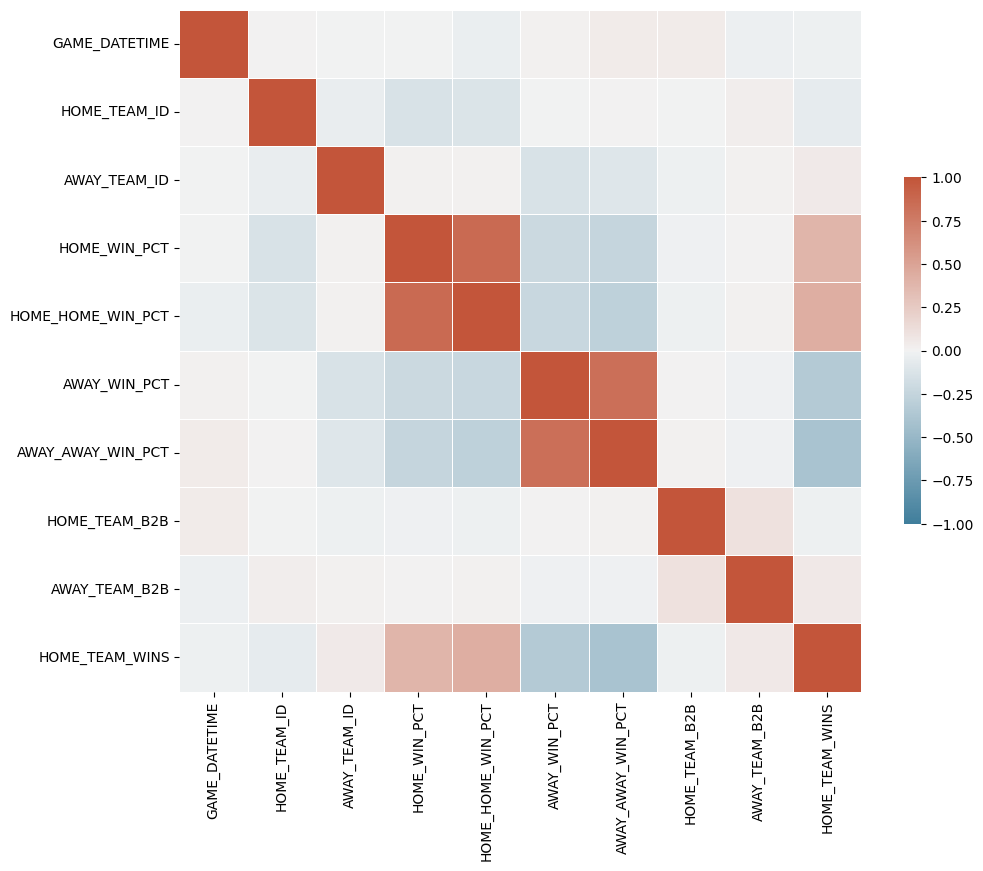

In [138]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=1, center=0, vmin=-1, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

## Training the model

In [139]:
train = games.loc[(games['SEASON'] >= 2007) & (games['SEASON'] <= 2022)]

X_train, y_train = train[feat_cols], train[target]

test = games.loc[(games['SEASON'] == 2023)]
X_test, y_test = test[feat_cols], test[target]

In [140]:
from sklearn.ensemble import RandomForestClassifier

In [141]:
clf = RandomForestClassifier(random_state=42, n_jobs=2, n_estimators=100, max_depth=7, bootstrap=True)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_jobs=2, random_state=42)

In [142]:
print('Train accuracy:',clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))

Train accuracy: 0.7693507229940459
Test accuracy: 0.7528455284552845


# Testing Results in a single season
Going to take the first half of the season (60%, 70%, etc), and see if model predictions hold. I think this will present a more realistic use case, because so much changes over the offseason. Let the first half of the season, happen, then use the first half data to predict second half results.

In [143]:
season_2023 = games.loc[(games['SEASON'] == 2023)].sort_values(by="GAME_DATETIME")

In [144]:
train_1, train_2, test = np.array_split(season_2023, 3)
train = pd.concat([train_1, train_2])
X_train, y_train = train[feat_cols], train[target]

X_test, y_test = test[feat_cols], test[target]

In [145]:
clf = RandomForestClassifier(random_state=42, n_jobs=2, n_estimators=100, max_depth=7, bootstrap=True)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_jobs=2, random_state=42)

In [146]:
print('Train accuracy:',clf.score(X_train, y_train))
print('Test accuracy:', clf.score(X_test, y_test))

Train accuracy: 0.8841463414634146
Test accuracy: 0.6853658536585366


# Comparing results across all seasons

In [147]:
def calculate_season(s):
  season = games.loc[(games['SEASON'] == s)].sort_values(by="GAME_DATETIME")
  train_1, train_2, test = np.array_split(season, 3)
  train = pd.concat([train_1, train_2])
  X_train, y_train = train[feat_cols], train[target]

  X_test, y_test = test[feat_cols], test[target]
  clf = RandomForestClassifier(random_state=42, n_jobs=2, n_estimators=100, max_depth=7, bootstrap=True)
  clf.fit(X_train, y_train)
  print('Train accuracy:',clf.score(X_train, y_train))
  print('Test accuracy:', clf.score(X_test, y_test))
  importances = clf.feature_importances_
  plt.figure(figsize=(8, 4))
  plt.barh(feat_cols, importances, color='skyblue')
  plt.xlabel('Gini Importance')
  plt.title('Feature Importance - Gini Importance')
  plt.gca().invert_yaxis()  # Invert y-axis for better visualization
  plt.show()

******* CALCULATING SEASON **********
2017
Train accuracy: 0.8829268292682927
Test accuracy: 0.7341463414634146


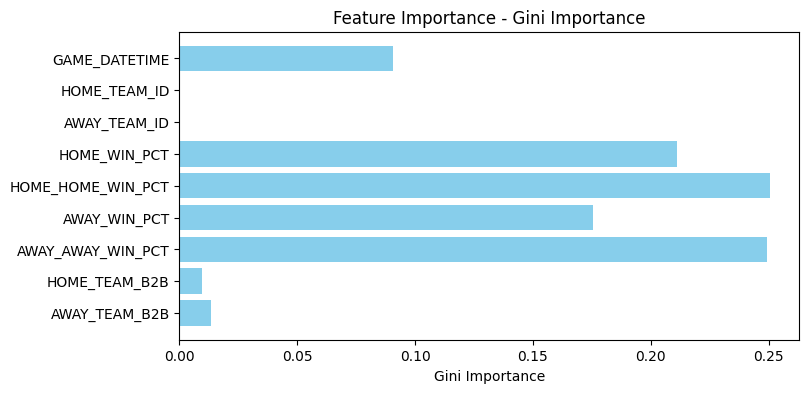

******* CALCULATING SEASON **********
2018
Train accuracy: 0.8914634146341464
Test accuracy: 0.6926829268292682


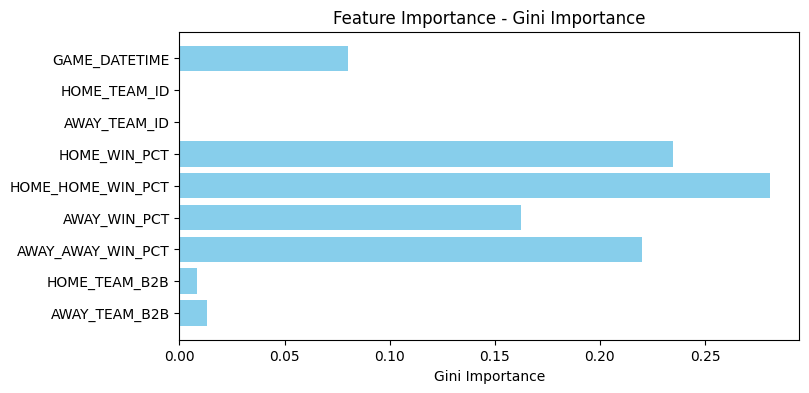

******* CALCULATING SEASON **********
2019
Train accuracy: 0.921875
Test accuracy: 0.6524216524216524


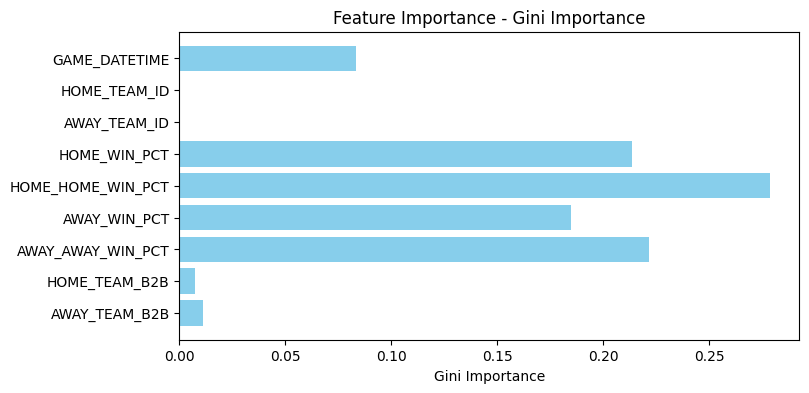

******* CALCULATING SEASON **********
2020
Train accuracy: 0.874826147426982
Test accuracy: 0.6796657381615598


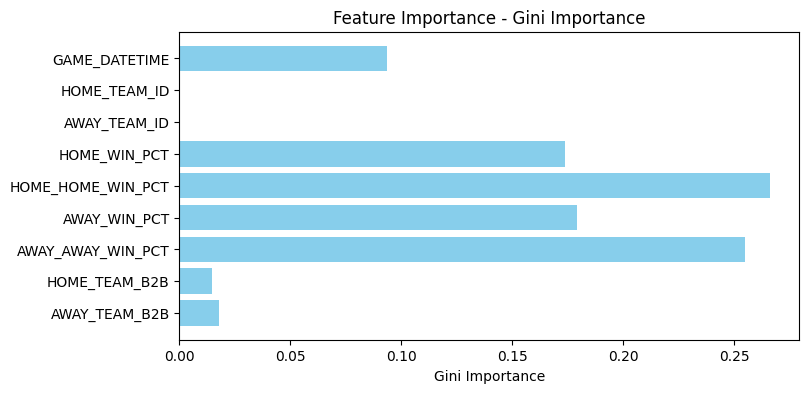

******* CALCULATING SEASON **********
2021
Train accuracy: 0.8621951219512195
Test accuracy: 0.6707317073170732


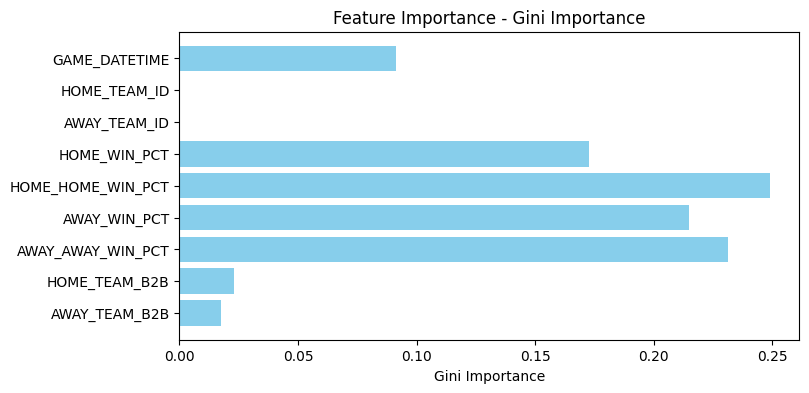

******* CALCULATING SEASON **********
2022
Train accuracy: 0.8477466504263094
Test accuracy: 0.6804878048780488


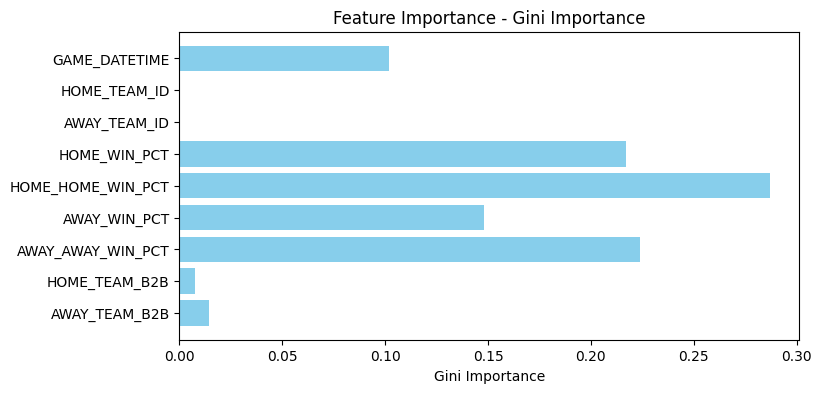

******* CALCULATING SEASON **********
2023
Train accuracy: 0.8841463414634146
Test accuracy: 0.6853658536585366


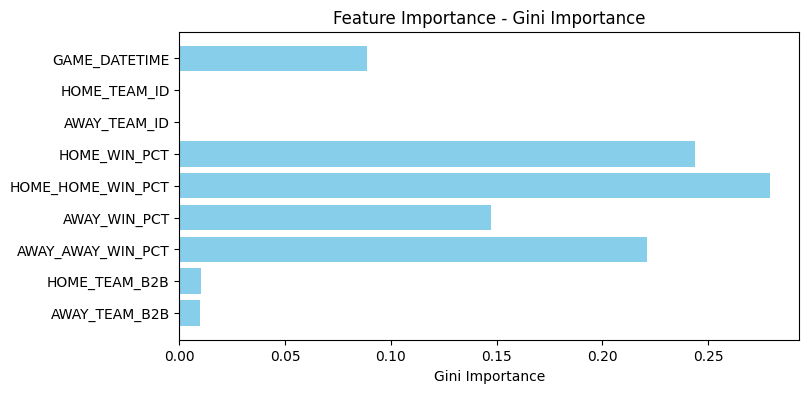

In [148]:
import warnings
warnings.filterwarnings('ignore')
for s in range(2017, 2024):
    print("******* CALCULATING SEASON **********")
    print(s)
    calculate_season(s)

## Results

First pass at the model not bad - roughly 68% when testing

In [150]:
games.to_csv('data/02_prediction_model.csv', index=False)